In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi
import anndata
import pandas as pd
import tools
import logging
# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [3]:
adata_multi = sc.read_h5ad("halo/E18_mouse_Brain/multiomic.h5ad")
adata_multi

AnnData object with n_obs × n_vars = 3365 × 176722
    obs: 'celltype'
    var: 'gene_ids', 'feature_types'

In [4]:
adata_multi.obs.head(15)

,celltype
AAACAGCCAACCGCCA-1,Upper Layer
AAACAGCCAAGGTCGA-1,"RG, Astro, OPC"
AAACAGCCAGGAACAT-1,Deeper Layer
AAACAGCCATATTGAC-1,Deeper Layer
AAACAGCCATGGTTAT-1,Subplate
AAACATGCACTTACAG-1,Upper Layer
AAACCAACAACTGGGA-1,"RG, Astro, OPC"
AAACCGCGTCACCAAA-1,"RG, Astro, OPC"
AAACCGCGTGCAATGC-1,Upper Layer
AAACCGGCAACTAACT-1,Upper Layer


In [5]:
adata_multi.var.head(15)

,gene_ids,feature_types
Xkr4,ENSMUSG00000051951,Gene Expression
Gm1992,ENSMUSG00000089699,Gene Expression
Gm19938,ENSMUSG00000102331,Gene Expression
Gm37381,ENSMUSG00000102343,Gene Expression
Rp1,ENSMUSG00000025900,Gene Expression
Sox17,ENSMUSG00000025902,Gene Expression
Gm37587,ENSMUSG00000104238,Gene Expression
Gm37323,ENSMUSG00000104328,Gene Expression
Mrpl15,ENSMUSG00000033845,Gene Expression
Lypla1,ENSMUSG00000025903,Gene Expression


In [2]:
### test whole data with RNA only 
adata_multi = sc.read_h5ad("halo/E18_mouse_Brain/multiomic.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)

df_meta= pd.read_csv("halo/E18_mouse_Brain/RNA/metadata.tsv",sep = "\t",index_col=0)
bins = df_meta.binned.unique()
times = {}
index = 0
for bin in sorted(bins):
    times[bin] = index
    index += 1

def add_time(row, times):
    timestamp = times[row.binned]
    return timestamp

df_meta['time_key'] = df_meta.apply(lambda row: add_time(row, times), axis=1)

newindex = []

for idx, row in df_meta.iterrows():
    newindex.append(idx+"_paired")

df_meta['Id'] = newindex    

df_meta_sub = df_meta[["Id", 'latent_time']]

df_meta_sub.set_index("Id", inplace=True)
adata_mvi.obs = adata_mvi.obs.join(df_meta_sub, how="inner")
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [3]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 8, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [4]:
model = model.load("model_sparse_BM_mouse", adata_mvi)

INFO     File model_sparse_BM_mouse/model.pt already downloaded                              
n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 8, n_hidden_global 128, n_cat_list [1], *cat_list 1


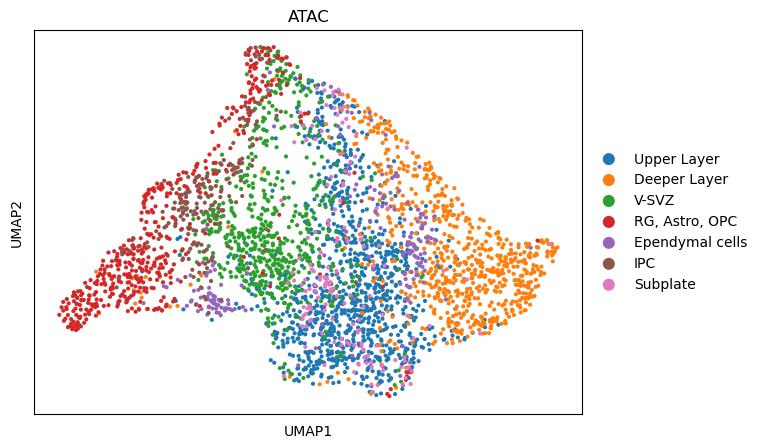

In [12]:
import matplotlib.pyplot as plt


latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()
adata_mvi.obsm["latent"] = latent_acc
sc.pp.neighbors(adata_mvi, use_rep="latent", n_neighbors=25)

sc.tl.umap(adata_mvi,min_dist =0.5)
# sc.tl.louvain(adata_mvi)

%matplotlib inline
# sc.pl.umap(adata_mvi, color=['celltype'])
sc.pl.scatter(adata_mvi,color='celltype',basis='umap',
             title = 'ATAC')
plt.show()

In [13]:
## functions split the RNa data
from sklearn.preprocessing import normalize


rna_index = adata_mvi.var['modality'] =="Gene Expression"
rna_data = anndata.AnnData(X=adata_mvi.X[:, rna_index],
                            obs=adata_mvi.obs, 
                            var=adata_mvi.var[rna_index])
rna_data.obsm['latent'] =      latent_expr
rna_data.obs['latent_decouple'] =    np.mean(latent_expr[:, :5], axis = 1)
rna_data.obs['latent_couple'] =    np.mean(latent_expr[:, 5:], axis = 1)

rna_data.obs['latent_1'] =   latent_expr[:, 0]
rna_data.obs['latent_2'] =   latent_expr[:, 1]
rna_data.obs['latent_3'] =   latent_expr[:, 2]
rna_data.obs['latent_4'] =   latent_expr[:, 3]
rna_data.obs['latent_5'] =   latent_expr[:, 4]
rna_data.obs['latent_6'] =   latent_expr[:, 5]
rna_data.obs['latent_7'] =   latent_expr[:, 6]
rna_data.obs['latent_8'] =   latent_expr[:, 7]
rna_data.obs['latent_9'] =   latent_expr[:, 8]
rna_data.obs['latent_10'] =   latent_expr[:, 9]

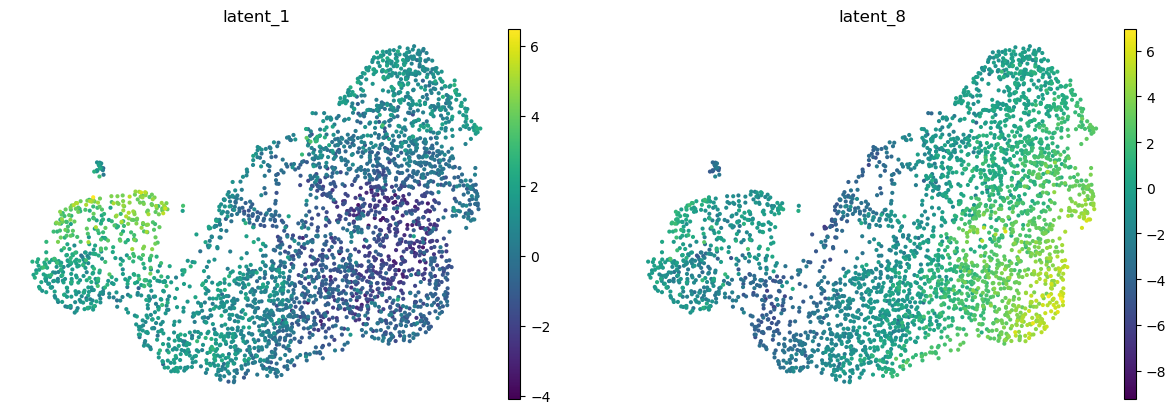

In [8]:
sc.pp.neighbors(rna_data, use_rep="latent", n_neighbors=25)
sc.tl.umap(rna_data)
sc.pl.umap(rna_data, color = ['latent_1','latent_8'], frameon=False, palette='viridis')

In [14]:
rna_data.write_h5ad("data/datasets/mouse_brain_rna.h5ad")

In [6]:
## some latent variables umap
## functions split the atac seq data and RNA seq data
from sklearn.preprocessing import normalize


atac_index = adata_mvi.var['modality'] =="Peaks"
atac_data = anndata.AnnData(X=adata_mvi.X[:, atac_index],
                            obs=adata_mvi.obs, 
                            var=adata_mvi.var[atac_index])
atac_data.obsm['latent'] =      latent_acc
atac_data.obs['latent_decouple'] =    np.mean(latent_acc[:, :5], axis = 1)
atac_data.obs['latent_couple'] =    np.mean(latent_acc[:, 5:], axis = 1)

atac_data.obs['latent_1'] =   latent_acc[:, 0]
atac_data.obs['latent_2'] =   latent_acc[:, 1]
atac_data.obs['latent_3'] =   latent_acc[:, 2]
atac_data.obs['latent_4'] =   latent_acc[:, 3]
atac_data.obs['latent_5'] =   latent_acc[:, 4]
atac_data.obs['latent_6'] =   latent_acc[:, 5]
atac_data.obs['latent_7'] =   latent_acc[:, 6]
atac_data.obs['latent_8'] =   latent_acc[:, 7]
atac_data.obs['latent_9'] =   latent_acc[:, 8]
atac_data.obs['latent_10'] =   latent_acc[:, 9]

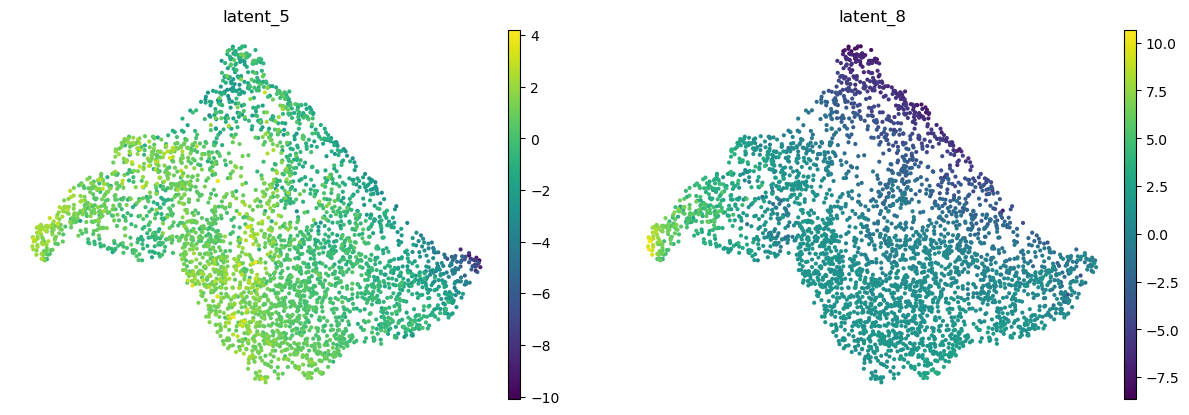

In [7]:
sc.pp.neighbors(atac_data, use_rep="latent", n_neighbors=25)
sc.tl.umap(atac_data)
sc.pl.umap(atac_data, color = ['latent_5','latent_8'], frameon=False, palette='viridis')

In [8]:
atac_data.var.head(3)

,gene_ids,feature_types,modality,n_cells
chr1:3094399-3095523,chr1:3094399-3095523,Peaks,Peaks,235
chr1:3113503-3114077,chr1:3113503-3114077,Peaks,Peaks,103
chr1:3119414-3121804,chr1:3119414-3121804,Peaks,Peaks,449


In [13]:
## preprocessing the RNA expression data
rna_data = anndata.read_h5ad("data/datasets/mouse_brain_rna.h5ad")
sc.pp.filter_genes(rna_data, min_cells=15)
rna_data.raw = rna_data
# rna_data


In [14]:
sc.pp.normalize_total(rna_data, target_sum=1e4)
sc.pp.log1p(rna_data)
sc.pp.highly_variable_genes(rna_data, min_disp = 0.2)
rna_data.var['exog'] = rna_data.var.highly_variable.copy()
rna_data.var['endog'] = rna_data.var.exog & (rna_data.var.dispersions_norm > 0.7)


In [16]:
rna_data.layers['counts'] = rna_data.raw.to_adata().X.copy()


In [19]:
rna_data.var['exog']

Xkr4               True
Gm1992            False
Gm19938           False
Rp1                True
Mrpl15            False
                  ...  
CAAA01118383.1    False
Vamp7             False
Tmlhe              True
4933409K07Rik     False
AC149090.1        False
Name: exog, Length: 14583, dtype: bool

In [20]:
rna_data.write_h5ad("data/datasets/mouse_brain_rna_exn.h5ad")

In [17]:
rna_data = anndata.read_h5ad("data/datasets/mouse_brain_rna_exn.h5ad")

In [11]:
## mapping the gene expression exg/endo to atac seq
## loading the atac annotation data
atac_annotation = pd.read_csv("data/datasets/e18_mouse_brain_fresh_5k_atac_peak_annotation.tsv", sep='\t')
atac_annotation.head(20)


,peak,gene,distance,peak_type
0,chr1_3094399_3095523,NaN,NaN,intergenic
1,chr1_3113503_3114077,NaN,NaN,intergenic
2,chr1_3119414_3121804,NaN,NaN,intergenic
3,chr1_3181343_3181401,NaN,NaN,intergenic
4,chr1_3198296_3198611,NaN,NaN,intergenic
5,chr1_3210204_3210605,NaN,NaN,intergenic
6,chr1_3292586_3292976,Xkr4;Gm1992,0;-173611,distal;distal
7,chr1_3371598_3371961,Xkr4;Gm1992,0;-94626,distal;distal
8,chr1_3399683_3400422,Xkr4;Gm1992,0;-66165,distal;distal
9,chr1_3406113_3406524,Xkr4;Gm1992,0;-60063,distal;distal


In [22]:
atac_data = anndata.read_h5ad("data/datasets/mouse_brain_atac_motifs.h5ad")
atac_data.var.head()



,chr,start,end,n_cells
peak_id,,,,
1,chr1,3094399,3095523,235
2,chr1,3113503,3114077,103
3,chr1,3119414,3121804,449
4,chr1,3198296,3198611,46
5,chr1,3210204,3210605,52


In [23]:
def generate_peakid(row):
    chr = row['chr']
    start = row["start"]
    end = row["end"]
    peak = chr+'_' + start+ '_' + end
    return peak

In [24]:
atac_data.var['peak'] =  atac_data.var.apply(generate_peakid, axis=1)
atac_data.var = atac_data.var.reset_index()
atac_data.var.head()



,peak_id,chr,start,end,n_cells,peak
0,1,chr1,3094399,3095523,235,chr1_3094399_3095523
1,2,chr1,3113503,3114077,103,chr1_3113503_3114077
2,3,chr1,3119414,3121804,449,chr1_3119414_3121804
3,4,chr1,3198296,3198611,46,chr1_3198296_3198611
4,5,chr1,3210204,3210605,52,chr1_3210204_3210605


In [25]:
new_var = pd.merge(atac_data.var, atac_annotation, left_on='peak', right_on='peak')

new_var.head(15)


,peak_id,chr,start,end,n_cells,peak,gene,distance,peak_type
0,1,chr1,3094399,3095523,235,chr1_3094399_3095523,NaN,NaN,intergenic
1,2,chr1,3113503,3114077,103,chr1_3113503_3114077,NaN,NaN,intergenic
2,3,chr1,3119414,3121804,449,chr1_3119414_3121804,NaN,NaN,intergenic
3,4,chr1,3198296,3198611,46,chr1_3198296_3198611,NaN,NaN,intergenic
4,5,chr1,3210204,3210605,52,chr1_3210204_3210605,NaN,NaN,intergenic
5,6,chr1,3292586,3292976,45,chr1_3292586_3292976,Xkr4;Gm1992,0;-173611,distal;distal
6,7,chr1,3371598,3371961,53,chr1_3371598_3371961,Xkr4;Gm1992,0;-94626,distal;distal
7,8,chr1,3399683,3400422,132,chr1_3399683_3400422,Xkr4;Gm1992,0;-66165,distal;distal
8,9,chr1,3477039,3477771,87,chr1_3477039_3477771,Xkr4;Gm1992,0;10453,distal;distal
9,10,chr1,3508598,3509041,55,chr1_3508598_3509041,Xkr4;Gm1992,0;42012,distal;distal


In [26]:
atac_data.var = new_var
atac_data.var.head(15)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


,peak_id,chr,start,end,n_cells,peak,gene,distance,peak_type
0,1,chr1,3094399,3095523,235,chr1_3094399_3095523,NaN,NaN,intergenic
1,2,chr1,3113503,3114077,103,chr1_3113503_3114077,NaN,NaN,intergenic
2,3,chr1,3119414,3121804,449,chr1_3119414_3121804,NaN,NaN,intergenic
3,4,chr1,3198296,3198611,46,chr1_3198296_3198611,NaN,NaN,intergenic
4,5,chr1,3210204,3210605,52,chr1_3210204_3210605,NaN,NaN,intergenic
5,6,chr1,3292586,3292976,45,chr1_3292586_3292976,Xkr4;Gm1992,0;-173611,distal;distal
6,7,chr1,3371598,3371961,53,chr1_3371598_3371961,Xkr4;Gm1992,0;-94626,distal;distal
7,8,chr1,3399683,3400422,132,chr1_3399683_3400422,Xkr4;Gm1992,0;-66165,distal;distal
8,9,chr1,3477039,3477771,87,chr1_3477039_3477771,Xkr4;Gm1992,0;10453,distal;distal
9,10,chr1,3508598,3509041,55,chr1_3508598_3509041,Xkr4;Gm1992,0;42012,distal;distal


In [27]:
rna_dict = rna_data.var.to_dict()
rna_dict.keys()

dict_keys(['gene_ids', 'feature_types', 'modality', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'])

In [28]:

def get_atac_exog(row, rna_dict):

    exog = False
    # endo = False
    genes = str(row["gene"])
    if genes == 'nan':
        return exog
    else:
        genes = genes.split(";")
        for g in genes:
            if g in rna_dict['exog'].keys():
                if rna_dict['exog'][g]:
                    exog = True
            # if g in rna_dict['endog'].keys():        
            #     if  rna_dict['endog'][g]:
            #         endo = True

    return exog


def get_atac_endog(row, rna_dict):

    endo = False
    genes = str(row["gene"])
    if genes == 'nan':
        return endo
    else:
        genes = genes.split(";")
        for g in genes:
    
            if g in rna_dict['endog'].keys():        
                if  rna_dict['endog'][g]:
                    endo = True
                

    return endo    


In [29]:
## add atac annotation
newvar = atac_data.var
newvar['exog'] =  newvar.apply(get_atac_exog, rna_dict=rna_dict,  axis=1)
newvar['endog'] =  newvar.apply(get_atac_endog, rna_dict=rna_dict,  axis=1)

newvar.head(15)

,peak_id,chr,start,end,n_cells,peak,gene,distance,peak_type,exog,endog
0,1,chr1,3094399,3095523,235,chr1_3094399_3095523,NaN,NaN,intergenic,False,False
1,2,chr1,3113503,3114077,103,chr1_3113503_3114077,NaN,NaN,intergenic,False,False
2,3,chr1,3119414,3121804,449,chr1_3119414_3121804,NaN,NaN,intergenic,False,False
3,4,chr1,3198296,3198611,46,chr1_3198296_3198611,NaN,NaN,intergenic,False,False
4,5,chr1,3210204,3210605,52,chr1_3210204_3210605,NaN,NaN,intergenic,False,False
5,6,chr1,3292586,3292976,45,chr1_3292586_3292976,Xkr4;Gm1992,0;-173611,distal;distal,True,False
6,7,chr1,3371598,3371961,53,chr1_3371598_3371961,Xkr4;Gm1992,0;-94626,distal;distal,True,False
7,8,chr1,3399683,3400422,132,chr1_3399683_3400422,Xkr4;Gm1992,0;-66165,distal;distal,True,False
8,9,chr1,3477039,3477771,87,chr1_3477039_3477771,Xkr4;Gm1992,0;10453,distal;distal,True,False
9,10,chr1,3508598,3509041,55,chr1_3508598_3509041,Xkr4;Gm1992,0;42012,distal;distal,True,False


In [30]:
atac_data.var = newvar.set_index('peak_id')

atac_data.var.head(10)


,chr,start,end,n_cells,peak,gene,distance,peak_type,exog,endog
peak_id,,,,,,,,,,
1,chr1,3094399,3095523,235,chr1_3094399_3095523,NaN,NaN,intergenic,False,False
2,chr1,3113503,3114077,103,chr1_3113503_3114077,NaN,NaN,intergenic,False,False
3,chr1,3119414,3121804,449,chr1_3119414_3121804,NaN,NaN,intergenic,False,False
4,chr1,3198296,3198611,46,chr1_3198296_3198611,NaN,NaN,intergenic,False,False
5,chr1,3210204,3210605,52,chr1_3210204_3210605,NaN,NaN,intergenic,False,False
6,chr1,3292586,3292976,45,chr1_3292586_3292976,Xkr4;Gm1992,0;-173611,distal;distal,True,False
7,chr1,3371598,3371961,53,chr1_3371598_3371961,Xkr4;Gm1992,0;-94626,distal;distal,True,False
8,chr1,3399683,3400422,132,chr1_3399683_3400422,Xkr4;Gm1992,0;-66165,distal;distal,True,False
9,chr1,3477039,3477771,87,chr1_3477039_3477771,Xkr4;Gm1992,0;10453,distal;distal,True,False


In [31]:
atac_data.write_h5ad("data/datasets/mouse_brain_atac_motifs_exn.h5ad")

In [61]:
print(type(atac_data.var.gene.unique()[1]))
a = [ e for e  in atac_data.var.gene.unique().tolist()]
b = []
for e in a:
    if ';' in str(e):
        b.append(e)
b        

<class 'str'>


['Xkr4;Gm1992',
 'Xkr4;Gm19938',
 'Rp1;Gm37381',
 'Sox17;Gm37587',
 'Rgs20;Gm16041',
 'Rgs20;Atp6v1h',
 'Rb1cc1;4732440D04Rik',
 'Adhfe1;2610203C22Rik',
 'Adhfe1;Vxn;2610203C22Rik',
 'Vxn;2610203C22Rik',
 'Vcpip1;1700034P13Rik',
 'Sgk3;1700034P13Rik',
 'Ppp1r42;Tcf24',
 'Cops5;Cspp1',
 'Cpa6;Arfgef1',
 'Prex2;A830018L16Rik',
 'Gm17644;Gm29663',
 'Ncoa2;Prdm14',
 'Msc;Gm9947',
 'Terf1;Kcnb2',
 'Rdh10;Rpl7',
 'Stau2;Ube2w',
 'Eloc;D030040B21Rik',
 'Jph1;Gm28376',
 'Gdap1;Gm28784',
 'Pi15;Gm28154',
 'Crispld1;Gm16070',
 'Tfap2d;Gm15825',
 'Tfap2b;Gm28340',
 'Pkhd1;4930486I03Rik',
 'Paqr8;6720483E21Rik',
 'Paqr8;Efhc1',
 'Tram2;Efhc1',
 'Tram2;Gm28287',
 'Kcnq5;Khdc1b',
 '4933415F23Rik;Gm29506',
 'Smap1;B3gat2',
 'Fam135a;Sdhaf4',
 'Col19a1;Col9a1',
 'Adgrb3;Gm29414',
 'Ptp4a1;Ptp4a1',
 '4931428L18Rik;Gm28644',
 '4931428L18Rik;Gm29128',
 'Lgsn;4931428L18Rik',
 'Khdrbs2;Gm5415',
 'Rab23;Bag2',
 'Zfp451;Bag2',
 'Dst;Bend6',
 'Dst;Gm26788',
 'Dst;Gm37958',
 'Imp4;Ccdc115;Gm28306',
 'Ptpn18;Gm

In [55]:
list('Xkr4;Gm1992')

['X', 'k', 'r', '4', ';', 'G', 'm', '1', '9', '9', '2']

In [35]:
rna_data.var

,gene_ids,feature_types,modality,n_cells,highly_variable,means,dispersions,dispersions_norm,exog,endog
Xkr4,ENSMUSG00000051951,Gene Expression,Gene Expression,2283,True,1.876801,2.101737,0.699344,True,False
Gm1992,ENSMUSG00000089699,Gene Expression,Gene Expression,443,False,0.124291,0.168296,-0.830691,False,False
Gm19938,ENSMUSG00000102331,Gene Expression,Gene Expression,683,False,0.228712,0.461415,-0.033439,False,False
Rp1,ENSMUSG00000025900,Gene Expression,Gene Expression,36,True,0.020071,0.943040,1.276528,True,True
Mrpl15,ENSMUSG00000033845,Gene Expression,Gene Expression,971,False,0.319294,0.355616,-0.493027,False,False
...,...,...,...,...,...,...,...,...,...,...
CAAA01118383.1,ENSMUSG00000063897,Gene Expression,Gene Expression,695,False,0.239101,0.455474,-0.049597,False,False
Vamp7,ENSMUSG00000051412,Gene Expression,Gene Expression,755,False,0.239121,0.339640,-0.364654,False,False
Tmlhe,ENSMUSG00000079834,Gene Expression,Gene Expression,559,True,0.223619,0.611113,0.373723,True,False
4933409K07Rik,ENSMUSG00000095552,Gene Expression,Gene Expression,52,False,0.012195,-0.123272,-1.623724,False,False


# Get the motif score and related files

## First get the genome right 

In [9]:
def parsing_chr_se(row):
    row = row['gene_ids']
    row = row.split("\t")[0]
    chrome = row[: row.find(":")]
    start = row[row.find(":")+1: row.find("-")]
    end = row[row.find("-")+1 :]
    newcol = pd.Series([chrome, start, end]) 
    return newcol

In [10]:
atac_data.var["peak_id"] = np.arange(1, atac_data.var.shape[0]+1)
atac_data.var[['chr', 'start', 'end']] =  atac_data.var.apply(parsing_chr_se, axis=1)

In [11]:
atac_data.var = atac_data.var[['peak_id', 'chr', 'start', 'end', "n_cells"]]
atac_data.var.reset_index(drop=True)
atac_data.var.set_index("peak_id",inplace=True)

In [12]:
atac_data.write_h5ad("data/datasets/mouse_brain_atac.h5ad")

In [21]:
atac_data = anndata.read_h5ad("data/datasets/mouse_brain_atac.h5ad")
atac_data.var.head()

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,chr,start,end,n_cells
peak_id,,,,
1,chr1,3094399,3095523,235
2,chr1,3113503,3114077,103
3,chr1,3119414,3121804,449
4,chr1,3198296,3198611,46
5,chr1,3210204,3210605,52


In [24]:
atac_index = adata_mvi.var['modality'] =="Peaks"
atac_data = anndata.AnnData(X=adata_mvi.X[:, atac_index],
                            obs=adata_mvi.obs, 
                            var=adata_mvi.var[atac_index])
atac_data.var.head()                            

,gene_ids,feature_types,modality,n_cells
chr1:3094399-3095523,chr1:3094399-3095523,Peaks,Peaks,235
chr1:3113503-3114077,chr1:3113503-3114077,Peaks,Peaks,103
chr1:3119414-3121804,chr1:3119414-3121804,Peaks,Peaks,449
chr1:3198296-3198611,chr1:3198296-3198611,Peaks,Peaks,46
chr1:3210204-3210605,chr1:3210204-3210605,Peaks,Peaks,52


In [12]:
atac_data.var['chr'].unique()

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr3', 'chr4', 'chr5',
       'chr6', 'chr7', 'chr8', 'chr9', 'chrX', 'chrY', 'GL456233.1',
       'JH584304.1', 'GL456216.1', 'JH584292.1', 'JH584295.1'],
      dtype=object)

In [27]:
# !wget https://hgdownload.soe.ucsc.edu/goldenPath/mm10/bigZips/mm10.fa.gz
# !gzip -d -f mm10.fa.gz

In [1]:
## Motif Analysis

from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
# from complementary_models import HALOMASKVIR as HALOVI
# from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi
import anndata
import pandas as pd
import tools
import logging



Global seed set to 0


In [2]:
## get the motif hits
atac_data = anndata.read_h5ad("data/datasets/mouse_brain_atac_motifs_exn.h5ad")
atac_data.var.head()
tools.motif_scan.logger.setLevel(logging.INFO)
tools.get_motif_hits_in_peaks(atac_data,
                    genome_fasta='mm10.fa',
                    chrom = 'chr', start = 'start', end = 'end')

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
INFO:tools.motif_scan:Getting peak sequences ...
123883it [00:01, 79741.50it/s]
INFO:tools.motif_scan:Scanning peaks for motif hits with p >= 0.0001 ...
INFO:tools.motif_scan:Building motif background models ...


Exception: Error while scanning for motifs: /bin/sh: 1: moods-dna.py: not found


In [10]:
atac_data.write_h5ad("data/datasets/mouse_brain_atac_motifs.h5ad")

In [5]:
atac_data = anndata.read_h5ad("data/datasets/mouse_brain_atac_motifs.h5ad")
atac_data.var.head()

,chr,start,end,n_cells
peak_id,,,,
1,chr1,3094399,3095523,235
2,chr1,3113503,3114077,103
3,chr1,3119414,3121804,449
4,chr1,3198296,3198611,46
5,chr1,3210204,3210605,52


In [6]:
import tools.adata_interface.utils as autils 
autils.fetch_factor_meta(atac_data).head(3)

,id,name,parsed_name
0,MA0973.1,CDF2,CDF2
1,MA1274.1,OBP3,OBP3
2,MA1559.1,SNAI3,SNAI3


In [5]:
autils.fetch_factor_hits(atac_data)

/home/haiyi/Desktop/HierachicalCausal_Omics/tools/adata_interface/utils.py:226: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  X = hits_matrix,
/home/haiyi/anaconda3/envs/halo2/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1646 × 123883
    obs: 'id', 'name', 'parsed_name'
    var: 'chr', 'start', 'end', 'n_cells'

In [6]:
## load RNA data
rna_data = anndata.read_h5ad("data/datasets/mouse_brain_rna.h5ad")
rna_data

AnnData object with n_obs × n_vars = 3365 × 14583
    obs: 'celltype', 'batch_id', 'modality', 'latent_time', '_scvi_batch', '_scvi_labels', 'latent_decouple', 'latent_couple', 'latent_1', 'latent_2', 'latent_3', 'latent_4', 'latent_5', 'latent_6', 'latent_7', 'latent_8', 'latent_9', 'latent_10'
    var: 'gene_ids', 'feature_types', 'modality', 'n_cells'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap', 'latent'
    obsp: 'connectivities', 'distances'

In [10]:
rna_data.var['gene_ids'].keys().tolist()

['Xkr4',
 'Gm1992',
 'Gm19938',
 'Rp1',
 'Mrpl15',
 'Lypla1',
 'Tcea1',
 'Rgs20',
 'Atp6v1h',
 'Rb1cc1',
 '4732440D04Rik',
 'St18',
 'Pcmtd1',
 'Gm26901',
 'Sntg1',
 'Rrs1',
 'Adhfe1',
 '2610203C22Rik',
 'Vxn',
 'Mybl1',
 'Vcpip1',
 '1700034P13Rik',
 'Sgk3',
 'Mcmdc2',
 'Snhg6',
 'Cops5',
 'Cspp1',
 'Arfgef1',
 'Cpa6',
 'Prex2',
 'A830018L16Rik',
 'Sulf1',
 'Slco5a1',
 'Ncoa2',
 'Gm29570',
 'Tram1',
 'Lactb2',
 'Eya1',
 'Kcnb2',
 'Terf1',
 '4930444P10Rik',
 'Rpl7',
 'Rdh10',
 'Gm28095',
 'Stau2',
 'Gm7568',
 'Ube2w',
 'Eloc',
 'Tmem70',
 'Ly96',
 'Gm28376',
 'Jph1',
 'Gdap1',
 'Gm16070',
 'Crispld1',
 'Gm28153',
 'Gm28756',
 'Gm15825',
 'Tfap2d',
 'Pkhd1',
 'Mcm3',
 'Paqr8',
 'Tram2',
 'Tmem14a',
 'Kcnq5',
 'Rims1',
 'Ogfrl1',
 'Gm28822',
 'B3gat2',
 'Smap1',
 'Sdhaf4',
 'Fam135a',
 'Col9a1',
 'Col19a1',
 'Lmbrd1',
 'Adgrb3',
 'Phf3',
 'Ptp4a1',
 'Ptp4a1-1',
 'Khdrbs2',
 'Gm5415',
 'Prim2',
 'Rab23',
 'Bag2',
 'Zfp451',
 'Bend6',
 'Dst',
 'Gm26788',
 'Gm37233',
 'Ccdc115',
 'Imp4',
 'A

In [11]:
autils.subset_factors(atac_data,
                          use_factors=[factor for factor in rna_data.var['gene_ids'].keys().tolist()
                                       if not ('FOS' in factor or 'JUN' in factor)])

In [8]:
atac_data.var

,chr,start,end,n_cells
peak_id,,,,
1,chr1,3094399,3095523,235
2,chr1,3113503,3114077,103
3,chr1,3119414,3121804,449
4,chr1,3198296,3198611,46
5,chr1,3210204,3210605,52
...,...,...,...,...
123879,GL456216.1,37994,39286,266
123880,GL456216.1,40534,41810,139
123881,GL456216.1,49045,49376,35


In [13]:
atac_data.write_h5ad("data/datasets/mouse_brain_atac_factored_motifs.h5ad")

In [1]:
## load the model and calculate the TF enrichement of different topics

from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi
import anndata
import pandas as pd
import tools
import logging

adata_multi = sc.read_h5ad("halo/E18_mouse_Brain/multiomic.h5ad")
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)

df_meta= pd.read_csv("halo/E18_mouse_Brain/RNA/metadata.tsv",sep = "\t",index_col=0)
bins = df_meta.binned.unique()
times = {}
index = 0
for bin in sorted(bins):
    times[bin] = index
    index += 1

def add_time(row, times):
    timestamp = times[row.binned]
    return timestamp

df_meta['time_key'] = df_meta.apply(lambda row: add_time(row, times), axis=1)

newindex = []

for idx, row in df_meta.iterrows():
    newindex.append(idx+"_paired")

df_meta['Id'] = newindex    

df_meta_sub = df_meta[["Id", 'latent_time']]

df_meta_sub.set_index("Id", inplace=True)
adata_mvi.obs = adata_mvi.obs.join(df_meta_sub, how="inner")
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))



HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

Global seed set to 0


n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 8, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [2]:
## get the enriched TFs analysis
## load the data
atac_data = anndata.read_h5ad("data/datasets/mouse_brain_atac_mira.h5ad")
atac_data.var.head()

,chr,start,end,n_cells
peak_id,,,,
1,chr1,3094399,3095523,235
2,chr1,3113503,3114077,103
3,chr1,3119414,3121804,449
4,chr1,3198296,3198611,46
5,chr1,3210204,3210605,52


In [3]:
## get the loading matrix
model = model.load("model_sparse_BM_mouse", adata_mvi)
loadings = model.get_atac_loading_global()
# latent_5_tf = pd.DataFrame(model.get_enriched_TFs(atac_data, topic_num=4, top_quantile=0.1, loadings=loadings))
# latent_5_tf.head()
loadings.shape

INFO     File model_sparse_BM_mouse/model.pt already downloaded                              
n_genes :14583
fine tune is False
gate decoder initialization n_input 10, n_output 123883,         n_hidden_local 8, n_hidden_global 128, n_cat_list [1], *cat_list 1


(80, 123883)

In [15]:
### merge the feature
aggregate_loadings = []
for i in range(10):
    aggregate_loadings.append(np.expand_dims(np.mean(loadings[i*8:(i+1)*8, :], axis=0),axis=0))
    print("element aggregate loadgins shape {}".format(aggregate_loadings[-1].shape))
aggregate_loadings = np.concatenate(aggregate_loadings, axis=0)


element aggregate loadgins shape (1, 123883)
element aggregate loadgins shape (1, 123883)
element aggregate loadgins shape (1, 123883)
element aggregate loadgins shape (1, 123883)
element aggregate loadgins shape (1, 123883)
element aggregate loadgins shape (1, 123883)
element aggregate loadgins shape (1, 123883)
element aggregate loadgins shape (1, 123883)
element aggregate loadgins shape (1, 123883)
element aggregate loadgins shape (1, 123883)


In [16]:
aggregate_loadings.shape

(10, 123883)

[Text(0.5, 14.722222222222216, 'Peaks')]

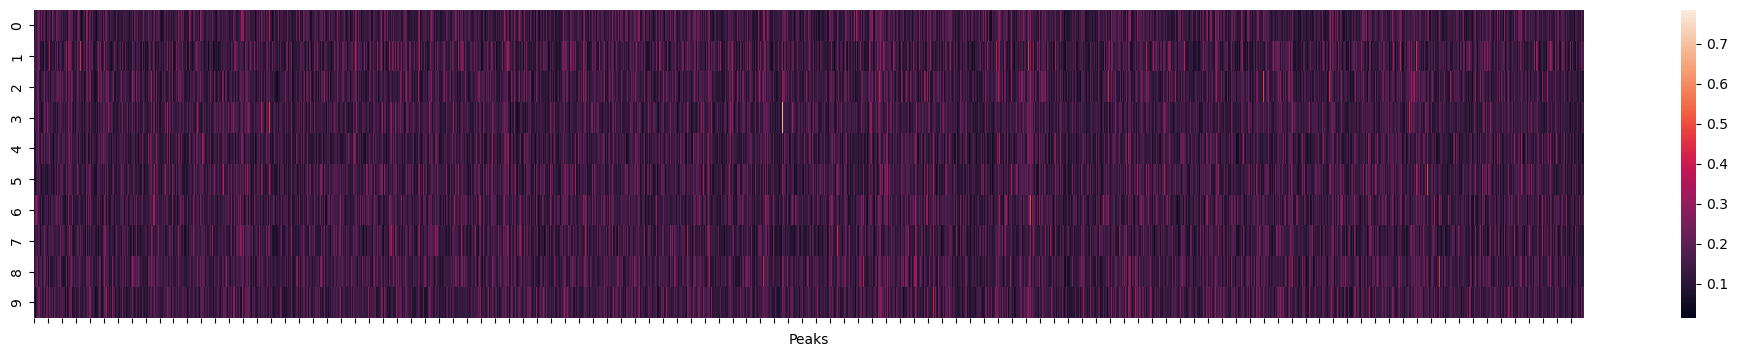

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

plt.figure(figsize=(25,4))
hm = sns.heatmap(aggregate_loadings)
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks") 

In [23]:
index = np.argsort(loadings[0, :])[::-1]
index = np.array(index[:int(37855 * 0.1)]).astype(int)
df = pd.DataFrame(data=index)
df.to_csv("global_merge_index.csv", sep=' ', header=False)


[Text(0.5, 14.722222222222216, 'Peaks')]

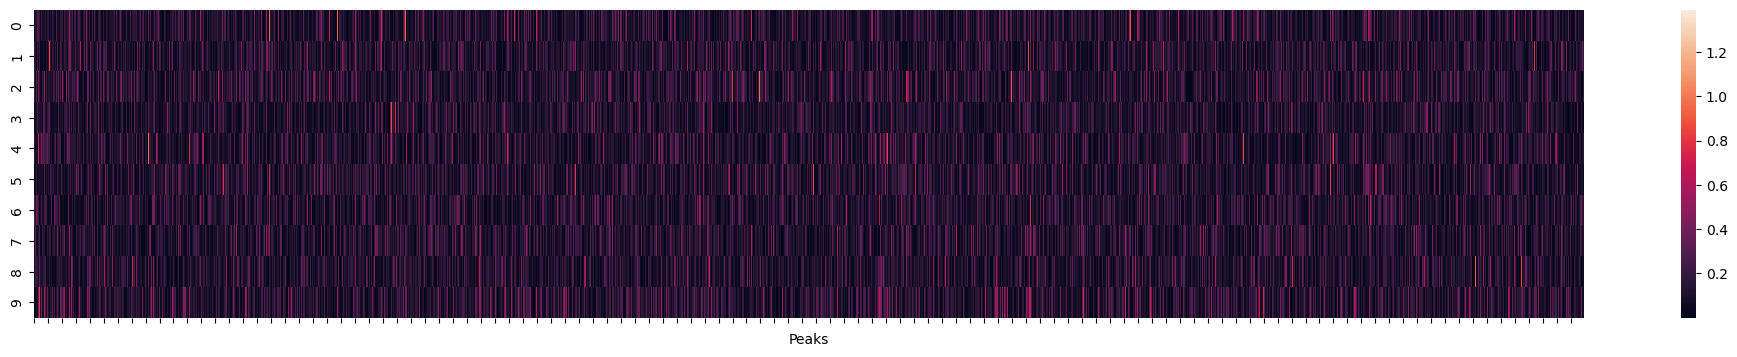

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize


plt.figure(figsize=(25,4))
# data = atac_data.X[:2, :].todense()
# print(data.shape)
# data =  normalize(data, norm='max').todense()
# loading = loadings[:, index_filtered]
# print(loading.shape)
# con = np.concatenate((data,loading), axis=0)
# hm = sns.heatmap(data)
hm = sns.heatmap(loadings[1:80:8,:])
hm.set(xticklabels=[]) 
hm.set(xlabel="Peaks") 

In [50]:
subloading = loadings[0:80:8]
index = np.argsort(loadings[0, :])[::-1]
index = index[:int(37855 * 0.1)]
[print(x) for x in index] 


46008
4984
88067
4964
113213
13441
95304
51910
108307
42152
2857
118394
25607
30596
119925
40978
86206
49653
95395
10798
70931
72120
101579
14474
51717
55489
71024
85870
98290
5022
112676
25824
56999
41955
28133
116105
97580
25946
78768
98184
123087
5583
37600
74455
43267
43017
78080
71504
112327
6616
14792
38743
2419
30531
71565
9215
64312
86773
33814
20139
28106
83136
37345
78664
37365
101588
86475
73009
40671
109408
20831
38789
89075
114349
61643
33848
59268
32371
66952
53704
61551
84719
53838
51985
68585
78722
41587
24697
21713
79296
115098
109061
105007
53681
28545
82476
39436
58960
13996
114711
24070
18910
84194
63197
38484
32548
109007
21547
92367
95900
9815
7545
75931
46439
119085
100639
32848
107276
13039
61646
47106
33512
8940
12956
91983
75281
17164
117956
31637
113105
37689
20017
35294
18215
52702
31994
97529
120792
46239
84497
18350
96688
5214
42062
73510
56856
57315
104881
49498
28714
49407
44925
43338
75233
79924
91328
68267
56345
48702
103351
17076
116046
51200
42543
10

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

<AxesSubplot:ylabel='Count'>

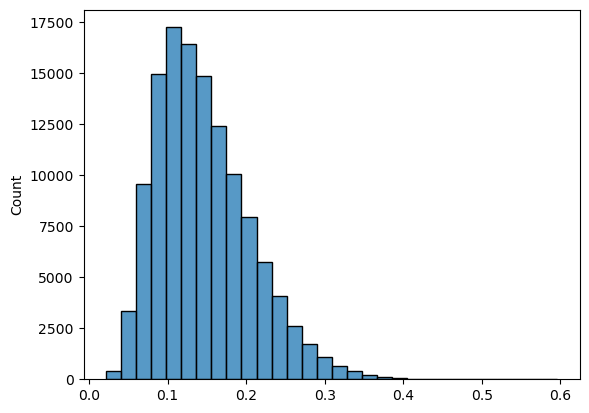

In [7]:
sns.histplot(data=loadings[0, :], bins=30)

In [15]:
subloading = loadings[0:80:8,:]
latent_5_tf, index_learnt = model.get_enriched_TFs(atac_data, topic_num=3, top_quantile=0.01, loadings=subloading, num_exo_features=37855)
latent_5_tf = pd.DataFrame(latent_5_tf)
latent_5_tf.head()

num of exo features 37855
zeros index len 50847
module_idx len before 378
module_idx len after 378


Finding enrichments:   0%|          | 0/1646 [00:00<?, ?it/s]

neither: 3132
neither: 0
neither: 3500
neither: 25094
neither: 12252
neither: 13717
neither: 0
neither: 12292
neither: 16689
neither: 17480
neither: 28615
neither: 18893
neither: 14472
neither: 0
neither: 2911
neither: 9479
neither: 1204
neither: 33079
neither: 25241
neither: 18783
neither: 6645
neither: 22014
neither: 30234
neither: 23082
neither: 17430
neither: 28073
neither: 24450
neither: 26321
neither: 0
neither: 22270
neither: 21118
neither: 27987
neither: 10917
neither: 27556
neither: 16374
neither: 14264
neither: 13432
neither: 29458
neither: 8598
neither: 0
neither: 24414
neither: 11852
neither: 21612
neither: 5549
neither: 23284
neither: 15533
neither: 0
neither: 0
neither: 30910
neither: 27857
neither: 8647
neither: 0
neither: 26799
neither: 24076
neither: 21446
neither: 12372
neither: 13525
neither: 8614
neither: 33409
neither: 18108
neither: 18180
neither: 23572
neither: 11021
neither: 13560
neither: 11733
neither: 22505
neither: 27102
neither: 12853
neither: 11166
neither

,id,name,parsed_name,pval,test_statistic
0,MA0973.1,CDF2,CDF2,1.0,0.093143
1,MA1274.1,OBP3,OBP3,1.0,0.000000
2,MA1559.1,SNAI3,SNAI3,1.0,0.115743
3,MA0068.2,PAX4,PAX4,1.0,0.367301
4,MA1063.1,TCP19,TCP19,1.0,0.539978


In [23]:
latent_5_tf.sort_values(by=['pval']).head(20)


,id,name,parsed_name,pval,test_statistic
1052,MA0374.1,RSC3,RSC3,3.309525e-40,4.273570
365,MA1001.2,ERF11,ERF11,5.031200e-36,3.732958
223,MA0992.2,ERF4,ERF4,2.911138e-35,3.665100
1565,MA1053.1,ERF109,ERF109,3.168226e-32,3.435366
487,MA0375.1,RSC30,RSC30,5.493641e-32,3.429954
765,MA0361.1,RDS1,RDS1,9.625527e-32,3.424424
1055,MA0994.1,ERF8,ERF8,1.119586e-31,3.407489
490,MA0993.1,ERF7,ERF7,1.096424e-29,3.259295
335,MA1052.1,RAP2-6,RAP2,5.483764e-29,3.210646
372,MA1034.1,OS05G0497200,OS05G0497200,8.081857e-29,3.203856


In [42]:
# latent_5_tf = pd.DataFrame(model.get_enriched_TFs(atac_data, topic_num=4, top_quantile=0.1, loadings=loadings))
subloading = loadings[7:80:8,:]
latent_8_tf, index_learnt = model.get_enriched_TFs(atac_data, topic_num=7, top_quantile=0.01, loadings=subloading,  num_exo_features=37855)
latent_8_tf = pd.DataFrame(latent_8_tf)
latent_8_tf.sort_values(by=['pval'])


num of exo features 37855
zeros index len 59111
module_idx len before 378
module_idx len after 378


Finding enrichments:   0%|          | 0/1646 [00:00<?, ?it/s]

neither: 2996
neither: 0
neither: 3335
neither: 25053
neither: 12088
neither: 13604
neither: 0
neither: 12184
neither: 16636
neither: 17419
neither: 28529
neither: 18778
neither: 14324
neither: 0
neither: 2759
neither: 9333
neither: 1069
neither: 33023
neither: 25018
neither: 18716
neither: 6522
neither: 21976
neither: 30098
neither: 22855
neither: 17335
neither: 27954
neither: 24365
neither: 26155
neither: 0
neither: 22197
neither: 21067
neither: 27915
neither: 10833
neither: 27417
neither: 16266
neither: 14170
neither: 13261
neither: 29402
neither: 8431
neither: 0
neither: 24211
neither: 11735
neither: 21534
neither: 5438
neither: 23219
neither: 15346
neither: 0
neither: 0
neither: 30813
neither: 27775
neither: 8510
neither: 0
neither: 26719
neither: 23871
neither: 21364
neither: 12310
neither: 13383
neither: 8480
neither: 33369
neither: 18037
neither: 18062
neither: 23381
neither: 10925
neither: 13432
neither: 11660
neither: 22424
neither: 27020
neither: 12743
neither: 11077
neither

,id,name,parsed_name,pval,test_statistic
71,MA0353.1,PDR3,PDR3,0.997891,0.160848
1561,MA0529.2,BEAF-32,BEAF,0.999997,0.125228
1642,MA0930.1,ABF3,ABF3,0.999999,0.156553
964,MA0963.1,BHLH78,BHLH78,0.999999,0.119350
306,MA1045.1,NAC043,NAC043,0.999999,0.247364
...,...,...,...,...,...
598,MA0248.1,TUP,TUP,1.000000,0.090920
597,MA0238.1,PB,PB,1.000000,0.073825
595,MA1533.1,NR1I2,NR1I2,1.000000,0.093672
593,MA0614.1,FOXJ2,FOXJ2,1.000000,0.058808


In [11]:
latent_8_tf.sort_values(by=['pval'])


,id,name,parsed_name,pval,test_statistic
1456,MA1695.1,ARF36,ARF36,1.0,0.006808
1128,MA0795.1,SMAD3,SMAD3,1.0,0.080440
676,MA0608.1,CREB3L2,CREB3L2,1.0,0.083435
822,MA0986.1,DREB2C,DREB2C,1.0,0.074335
145,MA0318.1,HMRA2,HMRA2,1.0,0.039862
...,...,...,...,...,...
619,MA1462.1,VFL,VFL,1.0,0.032668
618,MA0918.1,UNC-62,UNC,1.0,0.000000
617,MA0357.1,PHO4,PHO4,1.0,0.082480
628,MA0194.1,LIM1,LIM1,1.0,0.058977


In [12]:
latent_1_tf, index_learnt = model.get_enriched_TFs(atac_data, topic_num=1, top_quantile=0.3, loadings=loadings,  num_exo_features=37855)
latent_1_tf = pd.DataFrame(latent_8_tf)
latent_1_tf.sort_values(by=['pval'])


num of exo features 37855


Finding enrichments:   0%|          | 0/1646 [00:00<?, ?it/s]

,id,name,parsed_name,pval,test_statistic
1456,MA1695.1,ARF36,ARF36,1.0,0.006808
1128,MA0795.1,SMAD3,SMAD3,1.0,0.080440
676,MA0608.1,CREB3L2,CREB3L2,1.0,0.083435
822,MA0986.1,DREB2C,DREB2C,1.0,0.074335
145,MA0318.1,HMRA2,HMRA2,1.0,0.039862
...,...,...,...,...,...
619,MA1462.1,VFL,VFL,1.0,0.032668
618,MA0918.1,UNC-62,UNC,1.0,0.000000
617,MA0357.1,PHO4,PHO4,1.0,0.082480
628,MA0194.1,LIM1,LIM1,1.0,0.058977


In [15]:
latent_1_tf, index_learnt = model.get_enriched_TFs(atac_data, topic_num=2, top_quantile=0.1, loadings=loadings,  num_exo_features=37855)
latent_1_tf = pd.DataFrame(latent_8_tf)
latent_1_tf.sort_values(by=['pval'])


num of exo features 37855


Finding enrichments:   0%|          | 0/1646 [00:00<?, ?it/s]

,id,name,parsed_name,pval,test_statistic
1456,MA1695.1,ARF36,ARF36,1.0,0.006808
1128,MA0795.1,SMAD3,SMAD3,1.0,0.080440
676,MA0608.1,CREB3L2,CREB3L2,1.0,0.083435
822,MA0986.1,DREB2C,DREB2C,1.0,0.074335
145,MA0318.1,HMRA2,HMRA2,1.0,0.039862
...,...,...,...,...,...
619,MA1462.1,VFL,VFL,1.0,0.032668
618,MA0918.1,UNC-62,UNC,1.0,0.000000
617,MA0357.1,PHO4,PHO4,1.0,0.082480
628,MA0194.1,LIM1,LIM1,1.0,0.058977


In [17]:
latent_1_tf, index_learnt = model.get_enriched_TFs(atac_data, topic_num=3, top_quantile=0.1, loadings=loadings,  num_exo_features=37855)
latent_1_tf = pd.DataFrame(latent_8_tf)
latent_1_tf.sort_values(by=['pval'])


num of exo features 37855


Finding enrichments:   0%|          | 0/1646 [00:00<?, ?it/s]

,id,name,parsed_name,pval,test_statistic
1456,MA1695.1,ARF36,ARF36,1.0,0.006808
1128,MA0795.1,SMAD3,SMAD3,1.0,0.080440
676,MA0608.1,CREB3L2,CREB3L2,1.0,0.083435
822,MA0986.1,DREB2C,DREB2C,1.0,0.074335
145,MA0318.1,HMRA2,HMRA2,1.0,0.039862
...,...,...,...,...,...
619,MA1462.1,VFL,VFL,1.0,0.032668
618,MA0918.1,UNC-62,UNC,1.0,0.000000
617,MA0357.1,PHO4,PHO4,1.0,0.082480
628,MA0194.1,LIM1,LIM1,1.0,0.058977


In [16]:
a = np.array([1,2,3,4, 0])
np.where(a==0)[0]


array([4])

In [21]:
sindex = np.array(np.argsort(a))
zeros= np.where(a==0)[0]
print(sindex, zeros)
np.setdiff1d(sindex, zeros)


[4 0 1 2 3] [4]


array([0, 1, 2, 3])